# Downscaling TROPOSIF Data

Author: James Yoon (jyyoon@uw.edu)

---

Last updated: 22 May 2025

This script reads in TROPOSIF data through two different methods. 

In [33]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from datetime import timedelta

# More uncommon imports -- make sure you have satellite_processing_functions.py in the same directory
import netCDF4 as nc
import geopandas as gpd
import shapely
import xesmf as xe
import re # Import regular expressions

from scipy.interpolate import LinearNDInterpolator as lNDI

from satellite_processing_functions import convert_to_string, new_grid, read_scattered_TROPOMI_data, regrid_scattered_data, read_viirs_data
from processing_viirs_sinusoidal_grid import sinusoidal_grid;

# Mapping functions -- not required to process the data, but nice to plot as a sanity check!
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%config InlineBackend.figure_format='retina'
plt.rcParams["font.family"] = "Arial"

def basemap():
    # Creates a fig and ax object with a map of the globe using the Cartopy library
    fig = plt.figure(figsize=(10,5));
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree()); # Can change the projection using different ccrs.__()
    color = 'gray' # Color of the map lines

    # Add in the coastlines, states, and country borders with 50 m resolution.
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5, edgecolor = color);

    return fig, ax;

# import warnings
# warnings.filterwarnings("ignore")

---
# Part I: Setting Up The Downscaling

Setting up some parameters, such as the time period we're interested in and the geographic region!

In [24]:
# Accounts for the 8-day (16-day period) VIIRS dataset
data_type = 'VIIRS_downscaling'

year_start = 2018
doys_start = 121

year_end = 2021
doys_end = 365

starting_date = pd.to_datetime(f'{year_start}-{doys_start}', format='%Y-%j')
ending_date = pd.to_datetime(f'{year_end}-{doys_end}', format='%Y-%j')
time_array = pd.to_datetime(np.arange(starting_date, ending_date, timedelta(days = 1)))

In [26]:
# Geolocations
region = 'PNW'

if region == 'California':
    # geolocation_bounds = [-124.541016, 32.405745, -113.686523, 42.049293]
    geolocation_bounds = [-123.206177,37.028869,-121.393433,38.436380]
elif region == 'PNW':
    geolocation_bounds = [-129.287109,43.197167,-115.378418,51.096623]
elif region == 'Sudd':
    geolocation_bounds = [29.245605, 5, 32.515283, 9.774025]

cell_size_lat = 0.025
cell_size_lon = 0.025

new_grid_interp = new_grid(geolocation_bounds[0], geolocation_bounds[1], geolocation_bounds[2], geolocation_bounds[3], cell_size_lat, cell_size_lon) # Creates new grid to interpolate onto.

---
# Part II: VIIRS Data Processing

We'll use the read_viirs_function from the satellite_processing_functions script to get the raw data, followed by regridding onto a regular grid.

In [27]:
def compile_viirs_data(viirs_fn, geolocation_bounds):
    df_day = pd.DataFrame()

    # Loop through files in the glob array
    for viirs_f in viirs_fn: 
        tile_data = read_viirs_data(viirs_f, geolocation_bounds)

        if len(tile_data) > 0:
            df_day = pd.concat([df_day, tile_data], ignore_index=True)

    return df_day;

In [ ]:
viirs_data = pd.DataFrame() # Will contain the final VIIRS product

for time in time_array: # times on VIIRS grid
    viirs_data = pd.DataFrame()
    year = time.year
    doy = str(time.dayofyear).zfill(3)
    
    viirs_fn = glob(f"/home/disk/hermes/jyyoon/Vegetation_Indices/VIIRS/{region}/VNP13A1.A{year}{doy}*.h5")

    if len(viirs_fn) == 0:
        print(f"No files available for {time}")
    else:
        df_tiles = compile_viirs_data(viirs_fn, geolocation_bounds);
        start_time = df_tiles['start_time'].values[0];
        end_time = df_tiles['end_time'].values[0];
    
        # Regrid the VIIRS/MODIS sinusoidal grid to a regular grid!
        gdf = gpd.GeoDataFrame(df_tiles, geometry = gpd.points_from_xy(df_tiles['lon'], df_tiles['lat'])) # Create a GeoDataFrame
        gdf = regrid_scattered_data(gdf, new_grid_interp, data_type);
        gdf['start_time'] = start_time;
        gdf['end_time'] = end_time;
        gdf = gdf.set_index(['start_time', 'lat', 'lon']).to_xarray()

        if len(viirs_data) == 0:
            viirs_data = gdf;
        else:
            viirs_data = xr.concat([viirs_data, gdf], dim = 'start_time')

    if len(viirs_data) > 0:
        viirs_data.to_netcdf(f"PNW_VIIRS/PNW_VIIRS_{year}-{doy}.nc")
    print(f'Finished processing {time} ****************************')

Skipped this tile because data doesn't intersect bounds.
Finished processing 2018-05-01 00:00:00 ****************************
No files available for 2018-05-02 00:00:00
Finished processing 2018-05-02 00:00:00 ****************************
No files available for 2018-05-03 00:00:00
Finished processing 2018-05-03 00:00:00 ****************************
No files available for 2018-05-04 00:00:00
Finished processing 2018-05-04 00:00:00 ****************************
No files available for 2018-05-05 00:00:00
Finished processing 2018-05-05 00:00:00 ****************************
No files available for 2018-05-06 00:00:00
Finished processing 2018-05-06 00:00:00 ****************************
No files available for 2018-05-07 00:00:00
Finished processing 2018-05-07 00:00:00 ****************************
No files available for 2018-05-08 00:00:00
Finished processing 2018-05-08 00:00:00 ****************************
Skipped this tile because data doesn't intersect bounds.
Finished processing 2018-05-09 00

---
# Part III: Interpolate VIIRS Data

We'll interpolate the VIIRS data in time to remove any missing data due to clouds.

In [56]:
files = glob("PNW_VIIRS/*.nc")

viirs_data = pd.DataFrame()
for f in files:
    ds_i = xr.open_dataset(f);

    if len(viirs_data) == 0:
        viirs_data = ds_i
    else:
        viirs_data = xr.concat([viirs_data, ds_i], dim = 'start_time')
viirs_data['NIRv'] = viirs_data['NIRv'].interpolate_na(dim = 'start_time', method = 'nearest', limit = 4, fill_value="extrapolate")
viirs_data = viirs_data[['NIRv']]

In [40]:
# viirs_data = xr.open_dataset("PNW_VIIRS/PNW_VIIRS_2018-121.nc");
# viirs_data['NIRv'] = viirs_data['NIRv'].interpolate_na(dim = 'start_time', method = 'nearest', limit = 2, fill_value="extrapolate")

---
# Part IV: Upsample and Downscale SIF

We'll get the SIF data and downscale it to the VIIRS data!

In [ ]:
# SIF downscaling!
data_type = 'SIF';

for times in viirs_data.start_time.values:
    sif_gdf = pd.DataFrame(); # Contains 16-day SIF
    
    viirs_measurement = viirs_data.sel(start_time = times).to_dataframe().reset_index()
    viirs_measurement = gpd.GeoDataFrame(viirs_measurement, geometry = gpd.points_from_xy(viirs_measurement.lon, viirs_measurement.lat))

    datetimes_loop = pd.DataFrame(np.arange(pd.to_datetime(times), pd.to_datetime(times) + timedelta(days = 16), timedelta(days=1)), columns = ['day'])
    datetimes_loop['day'] = pd.to_datetime(datetimes_loop.day)
        
    for day in datetimes_loop['day']:
        year = str(day.year).zfill(2)
        month = str(day.month).zfill(2)
        date = str(day.day).zfill(2)

        time_string = f'{year}-{month}-{date}'
        sif_fns = glob(f"/home/disk/hermes/jyyoon/TROPOSIF/{year}/{month}/TROPOSIF_L2B_{year}-{month}-{date}.nc")

        for fn in sif_fns:
            try:
                gdf_i = pd.DataFrame()
                gdf_i = read_scattered_TROPOMI_data(fn, data_type, bounds = geolocation_bounds, geolocation = True);
                
                if (len(sif_gdf) == 0) & (len(gdf_i) > 0):
                    sif_gdf = gdf_i[['SIF_Corr_743', 'SIF_Corr_735', 'time', 'geometry']].copy()
                
                elif len(gdf_i) > 0:
                    sif_gdf = pd.concat([sif_gdf, gdf_i[['SIF_Corr_743', 'SIF_Corr_735', 'time', 'geometry']]], axis = 0)  
            except:
                print(f"Could not read in {day}.")
        
    spatial_joined = gpd.sjoin(viirs_measurement.dropna(subset = ['NIRv']), sif_gdf, how='left', predicate='within')
    
    mean_nirv_per_tropomi_pixel = spatial_joined[['index_right', 'NIRv']].groupby('index_right').mean()
    spatial_joined_with_mean = pd.merge(spatial_joined, mean_nirv_per_tropomi_pixel, left_on = 'index_right', right_on = 'index_right', suffixes = ['', '_mean'])
    
    spatial_joined_with_mean['SIF_upsampled_743'] = spatial_joined_with_mean['SIF_Corr_743'] # * (spatial_joined_with_mean['NIRv'] / spatial_joined_with_mean['NIRv_mean'])
    spatial_joined_with_mean['SIF_upsampled_735'] = spatial_joined_with_mean['SIF_Corr_735'] # * (spatial_joined_with_mean['NIRv'] / spatial_joined_with_mean['NIRv_mean'])

    upsampled_SIF = spatial_joined_with_mean[['lat', 'lon', 'SIF_upsampled_743', 'SIF_upsampled_735', 'NIRv']].groupby(['lat', 'lon']).mean().reset_index()
    upsampled_SIF['start_time'] = times
    gridded_upsampled_SIF = upsampled_SIF[['lat', 'lon', 'start_time', 'SIF_upsampled_743', 'SIF_upsampled_735', 'NIRv']].set_index(['start_time', 'lat', 'lon']).to_xarray()

    spatial_joined_with_mean['SIF_downscaled_743'] = spatial_joined_with_mean['SIF_Corr_743'] * (spatial_joined_with_mean['NIRv'] / spatial_joined_with_mean['NIRv_mean'])
    spatial_joined_with_mean['SIF_downscaled_735'] = spatial_joined_with_mean['SIF_Corr_735'] * (spatial_joined_with_mean['NIRv'] / spatial_joined_with_mean['NIRv_mean'])

    downscaled_SIF = spatial_joined_with_mean[['lat', 'lon', 'SIF_downscaled_743', 'SIF_downscaled_735', 'NIRv']].groupby(['lat', 'lon']).mean().reset_index()
    downscaled_SIF['start_time'] = times
    gridded_downscaled_SIF = downscaled_SIF[['lat', 'lon', 'start_time', 'SIF_downscaled_743', 'SIF_downscaled_735', 'NIRv']].set_index(['start_time', 'lat', 'lon']).to_xarray()

    gridded_upsampled_SIF.to_netcdf(f"Upsampled_SIF/Upscaled_SIF_{times}.nc")
    gridded_downscaled_SIF.to_netcdf(f"Downscaled_SIF/Downscaled_SIF_{times}.nc")

Could not read in 2018-06-16 00:00:00.
Could not read in 2018-06-16 00:00:00.


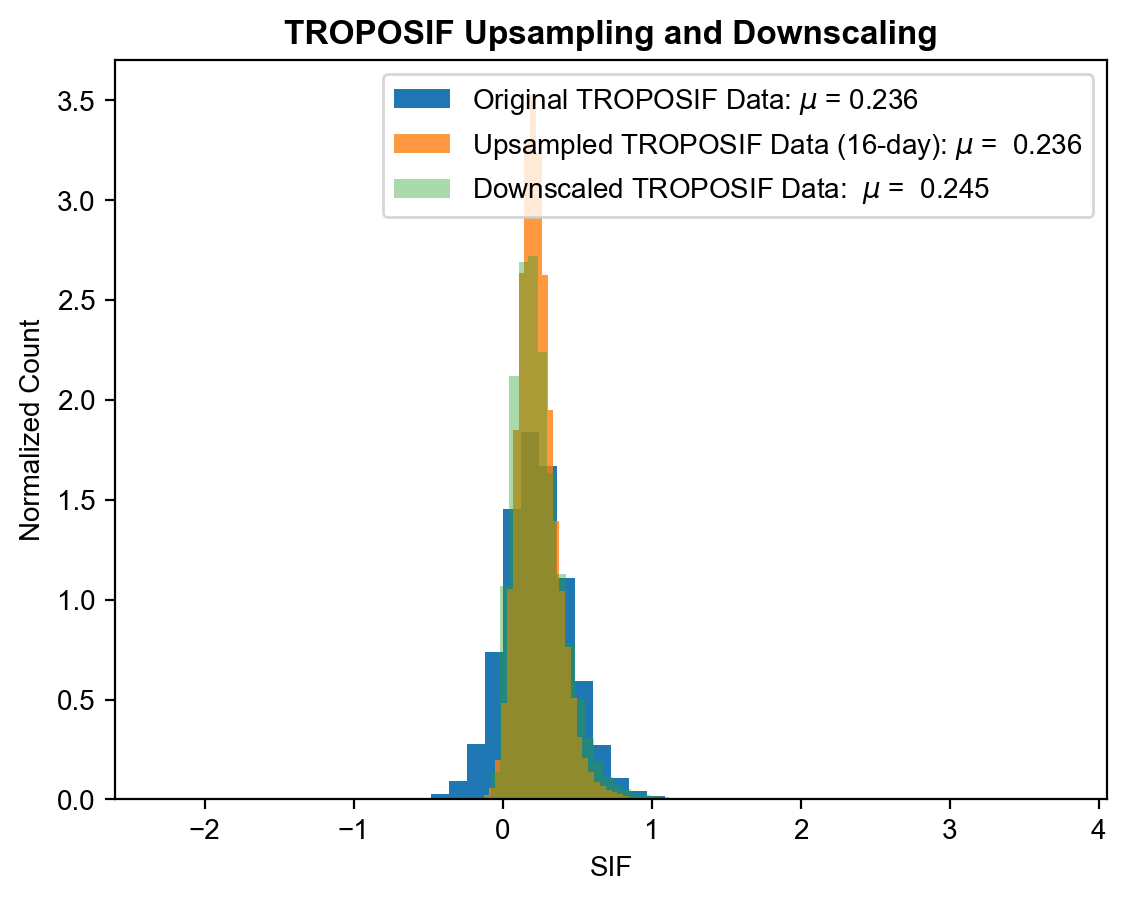

In [63]:
import seaborn as sns
fig, ax = plt.subplots()

ax.hist(sif_gdf.SIF_Corr_743, bins = 50, color = 'tab:blue', density = True, label = f'Original TROPOSIF Data: $\mu$ = {np.mean(sif_gdf.SIF_Corr_743) :.3f}')
ax.hist(gridded_upsampled_SIF.SIF_upsampled_743.to_numpy().flatten(), bins = 50, color = 'tab:orange', alpha = 0.8, density = True, label = f'Upsampled TROPOSIF Data (16-day): $\mu$ = {np.mean(gridded_upsampled_SIF.SIF_upsampled_743.to_dataframe().dropna()) : .3f}')
ax.hist(gridded_downscaled_SIF.SIF_downscaled_743.to_numpy().flatten(), bins = 50, color = 'tab:green', alpha = 0.4, density = True, label = f'Downscaled TROPOSIF Data:  $\mu$ = {np.mean(gridded_downscaled_SIF.SIF_downscaled_743.to_dataframe().dropna()) : .3f}')

ax.set_title("TROPOSIF Upsampling and Downscaling", weight = "bold")
ax.set_ylabel("Normalized Count")
ax.set_xlabel("SIF")
ax.legend()

Text(0.5, 1.0, 'Upsampled SIF')

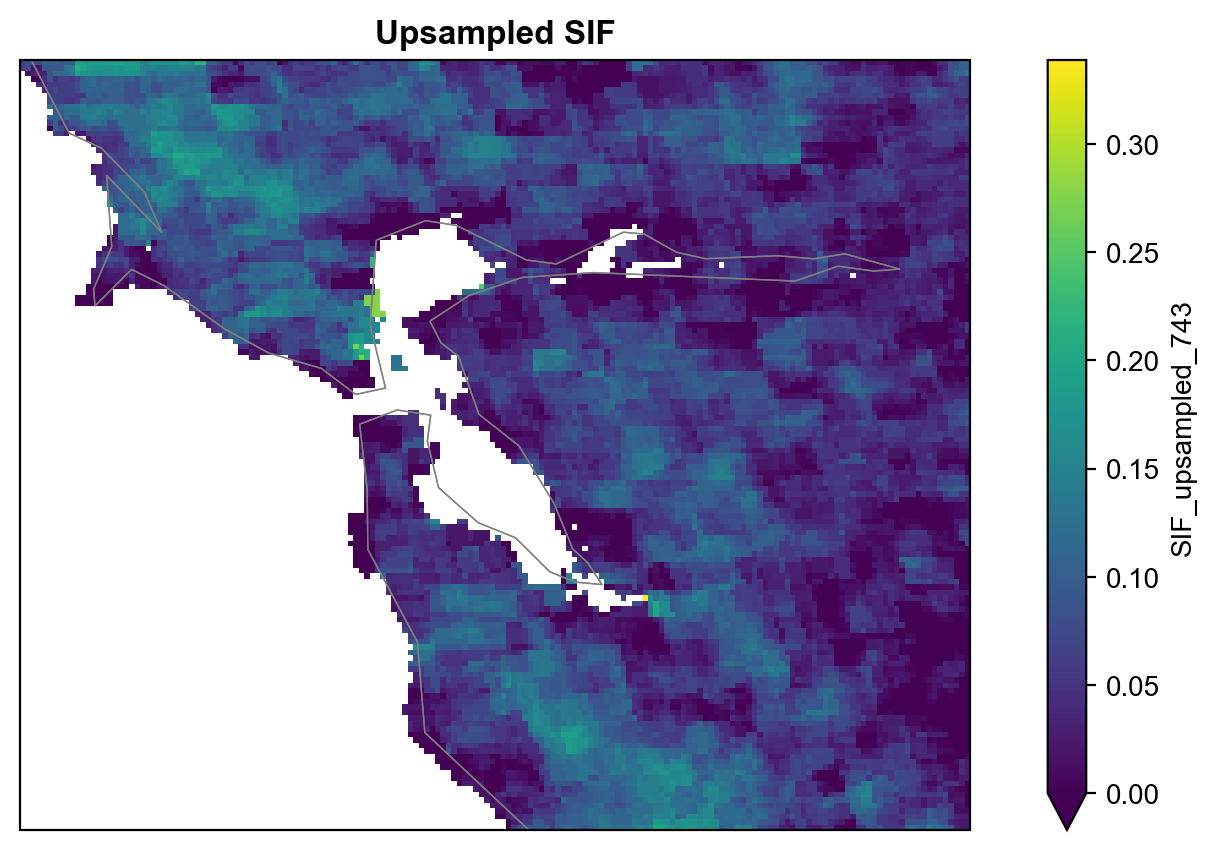

In [541]:
fig, ax = basemap()
im = gridded_upsampled_SIF.SIF_upsampled_743.plot(ax= ax, cmap = 'viridis', vmin = 0)
ax.set_title("Upsampled SIF", weight = "bold")

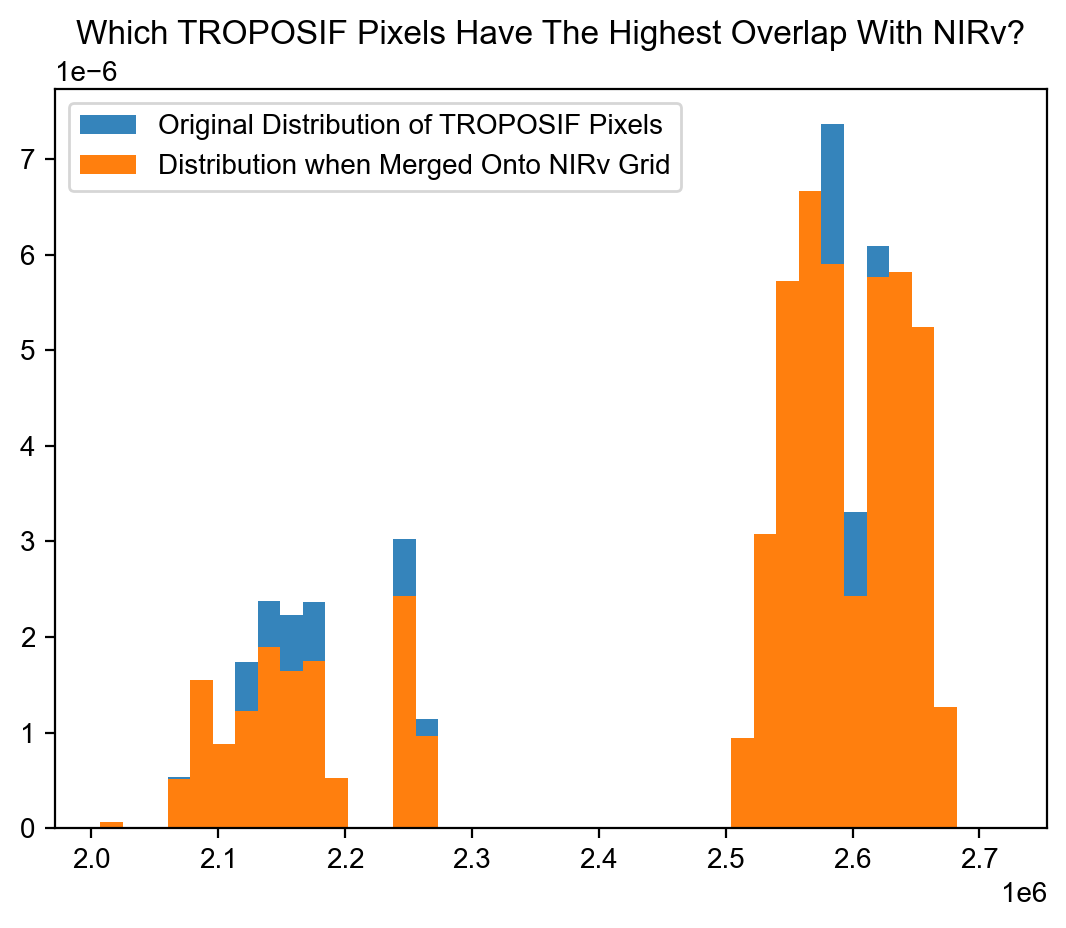

In [64]:
plt.hist(sif_gdf.index, density = True, alpha = 0.9, bins = 40, label = 'Original Distribution of TROPOSIF Pixels');
plt.hist(spatial_joined.index_right, density = True, alpha = 1, bins = 40, label = 'Distribution when Merged Onto NIRv Grid');
plt.title("Which TROPOSIF Pixels Have The Highest Overlap With NIRv?")
plt.legend()